In [ ]:
!pip install wandb

In [ ]:
import wandb
!wandb login

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [ ]:
import torch
from torchvision import transforms, datasets
import time
import random

In [ ]:
image_transforms = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=image_transforms
)

test_data = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=image_transforms
)

print(f'train size:{len(train_data)}')
print(f'test size:{len(test_data)}')

train size:60000
test size:10000


In [ ]:
config = {"batch_size" : 128,
          "lr" : 0.03,
          "epochs" : 10}

In [ ]:
VALIDATION_RATIO = 0.9

train_valid_ratio = [int(len(train_data)*VALIDATION_RATIO), len(train_data)-int(len(train_data)*VALIDATION_RATIO)]
train_valid_ratio

train_data, valid_data = torch.utils.data.random_split(train_data, train_valid_ratio)

In [ ]:
BATCH_SIZE = config["batch_size"]

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

print('No of batches:')
print(f'\ttraining: {len(train_loader)}')
print(f'\ttest: {len(test_loader)}')
print(f'\tvalid: {len(valid_loader)}')

No of batches:
	training: 422
	test: 79
	valid: 47


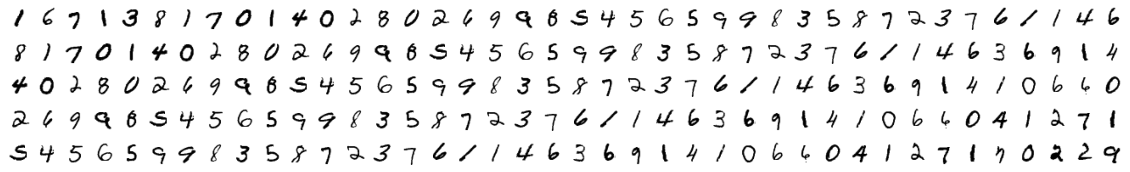

In [ ]:
import matplotlib.pyplot as plt

for i in train_loader:
  break
  
r, c = 5, 40
f, axarr = plt.subplots(r, c)
plt.rcParams["figure.figsize"] = (20,3)

for ii in range(r):
  for jj in range(c):
    axarr[ii, jj].imshow(i[0][r*ii+jj].numpy().squeeze(), cmap='gray_r')
    axarr[ii, jj].axis('off')


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MLP(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.fc1 = nn.Linear(28*28, 250)
    self.fc2 = nn.Linear(250, 100)
    self.fc3 = nn.Linear(100, 10)

  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

In [ ]:
def get_accuracy(output, label):
  pred = output.argmax(1, keepdim=False)
  correct = pred.eq(label.view_as(pred)).sum()
  acc = correct.float() / label.shape[0]
  return acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def train(model, error, optimizer, train_loader):
  train_loss = 0
  train_acc = 0
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(device)
    label = label.to(device)

    optimizer.zero_grad()
    output = model(image)

    loss = error(output, label)
    acc = get_accuracy(output, label)

    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_acc += acc.item()
  
  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  return train_loss, train_acc

In [ ]:
def validate(model, error, test_loader): 
  loss_valid = 0
  acc_valid = 0       
  model.eval()  

  for step in range(len(test_loader)):
    images , labels = next(iter(test_loader))
    
    images = images.to(device)
    labels = labels.to(device)
    
    output = model(images)
    
    loss_valid_step = error(output , labels)
    acc_valid_step = get_accuracy(output, labels)
  
    loss_valid += loss_valid_step.item()
    acc_valid += acc_valid_step.item()

  loss_valid /= len(test_loader)
  acc_valid /= len(test_loader)

  return loss_valid, acc_valid

In [ ]:
wandb.init(name = 'SIMPLE_MLP',
           project='MNIST',
           config=config,
           notes='simply testing the wandb package',
           tags=['MNIST', 'MLP', 'Introduction'])

error = nn.CrossEntropyLoss()
model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

wandb.watch(model)

EPOCHS = config['epochs']
start_time = time.time()

for epoch in range(1, EPOCHS+1):
  loss_train, acc_train = train(model, error, optimizer, train_loader)
  loss_valid, acc_valid = validate(model, error, valid_loader)

  print(f'\tTrain Loss: {loss_train:.3f} | Train Acc: {acc_train*100:.2f}%')
  print(f'\t Val. Loss: {loss_valid:.3f} |  Val. Acc: {acc_valid*100:.2f}%')

  wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid})
print("Time Elapsed : {:.4f}s".format(time.time() - start_time))

Epoch,▁▂▃▃▄▅▆▆▇█
Train Acc,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Valid Acc,▁▅▆▇▆▇▇█▆█
Valid Loss,▆▁▃▁▃▃▄▃█▄
Epoch,10
Train Acc,0.98056
Train Loss,0.07774
Valid Acc,0.97291
Valid Loss,0.16299


	Train Loss: 0.377 | Train Acc: 89.15%
	 Val. Loss: 0.243 |  Val. Acc: 93.30%
	Train Loss: 0.238 | Train Acc: 93.62%
	 Val. Loss: 0.248 |  Val. Acc: 93.48%
	Train Loss: 0.213 | Train Acc: 94.40%
	 Val. Loss: 0.224 |  Val. Acc: 94.48%
	Train Loss: 0.201 | Train Acc: 94.88%
	 Val. Loss: 0.246 |  Val. Acc: 94.02%
	Train Loss: 0.193 | Train Acc: 95.13%
	 Val. Loss: 0.278 |  Val. Acc: 93.98%
	Train Loss: 0.180 | Train Acc: 95.51%
	 Val. Loss: 0.174 |  Val. Acc: 95.40%
	Train Loss: 0.183 | Train Acc: 95.39%
	 Val. Loss: 0.283 |  Val. Acc: 94.13%
	Train Loss: 0.177 | Train Acc: 95.56%
	 Val. Loss: 0.229 |  Val. Acc: 94.83%
	Train Loss: 0.166 | Train Acc: 95.74%
	 Val. Loss: 0.223 |  Val. Acc: 95.79%
	Train Loss: 0.157 | Train Acc: 96.08%
	 Val. Loss: 0.273 |  Val. Acc: 95.00%
Time Elapsed : 54.2222s


In [ ]:
test_loss, test_acc = validate(model, error, test_loader)
print(f'test_loss:{test_loss}\ntest_acc:{test_acc}')

test_loss:0.281990845840943
test_acc:0.9501582278481012
